In [60]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import contractions

In [61]:
train = pd.DataFrame(pd.read_excel("Constraint_English_Train.xlsx",engine='openpyxl'))
test = pd.DataFrame(pd.read_excel("Constraint_English_Val.xlsx",engine='openpyxl'))


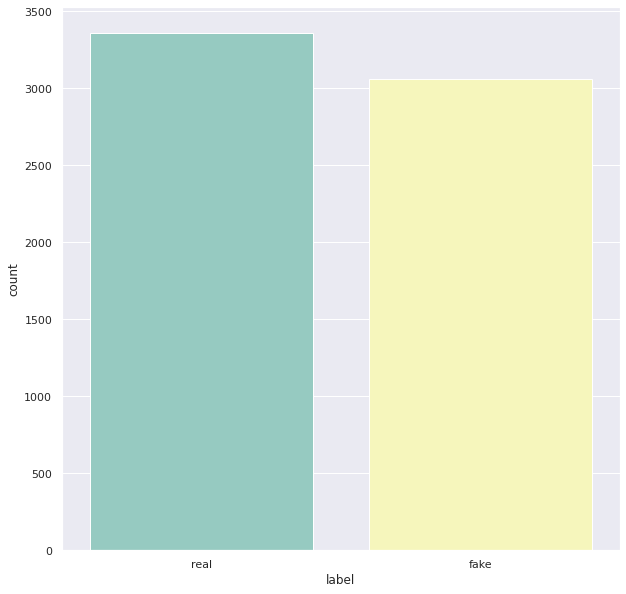

In [62]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize']=[10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.countplot(x='label', data=train, palette='Set3')
plt.show()

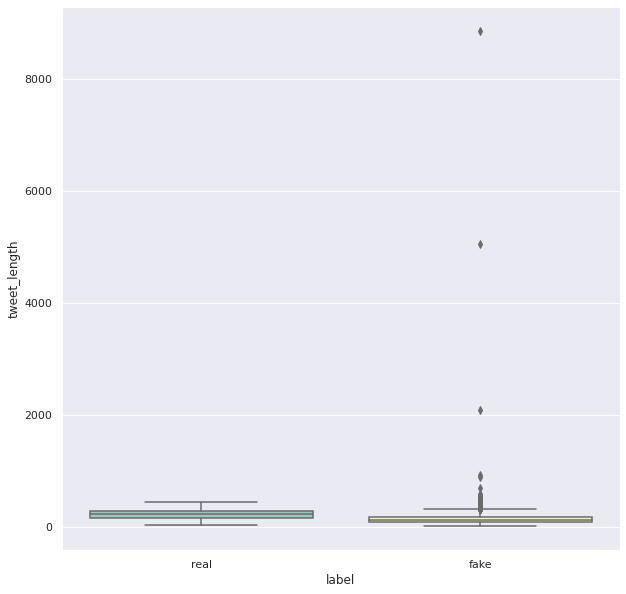

In [63]:
train["tweet_length"]=train['tweet'].apply(lambda x: len(x))
sns.boxplot(y="tweet_length",x='label',data=train,palette="Set3")
plt.show()

In [64]:
train["tweet"]=train['tweet'].str.strip()
print(len(train[train["tweet"]==0]))

0


In [65]:
def preprocess_text(x):
    #cleaned_text=re.sub(r'^https?:\/\/.*[\r\n]*', '',x, flags=re.MULTILINE)
    #cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', cleaned_text)
    cleaned_text=x
    word_list = []
    for each_word in cleaned_text.split(' '):
        try:
            word_list.append(contractions.fix(each_word).lower())
        except:
            print(x)
    return " ".join(word_list)

train["tweet"]=train["tweet"].apply(lambda x:preprocess_text(x))
test["tweet"]=test["tweet"].apply(lambda x:preprocess_text(x))

In [66]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

train['tweet']=train["tweet"].apply(lambda x: word_tokenize(x))
train["tweet"]=train["tweet"].apply(lambda x: [each_word for each_word in x if each_word not in stopwords.words('english')])

test['tweet']=test["tweet"].apply(lambda x: word_tokenize(x))
test["tweet"]=test["tweet"].apply(lambda x: [each_word for each_word in x if each_word not in stopwords.words('english')])

In [67]:
train["tweet"]=train["tweet"].apply(lambda x: " ".join(x))
test["tweet"]=test["tweet"].apply(lambda x: " ".join(x))

In [68]:
all_text_real=" ".join(train[train['label']=='real']['tweet'])
all_text_fake=" ".join(train[train['label']=='fake']['tweet'])


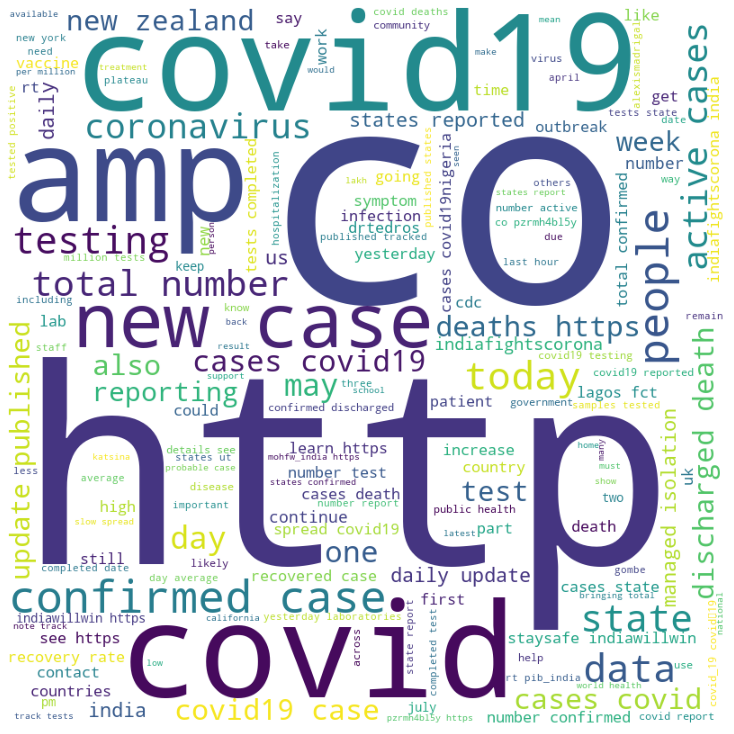

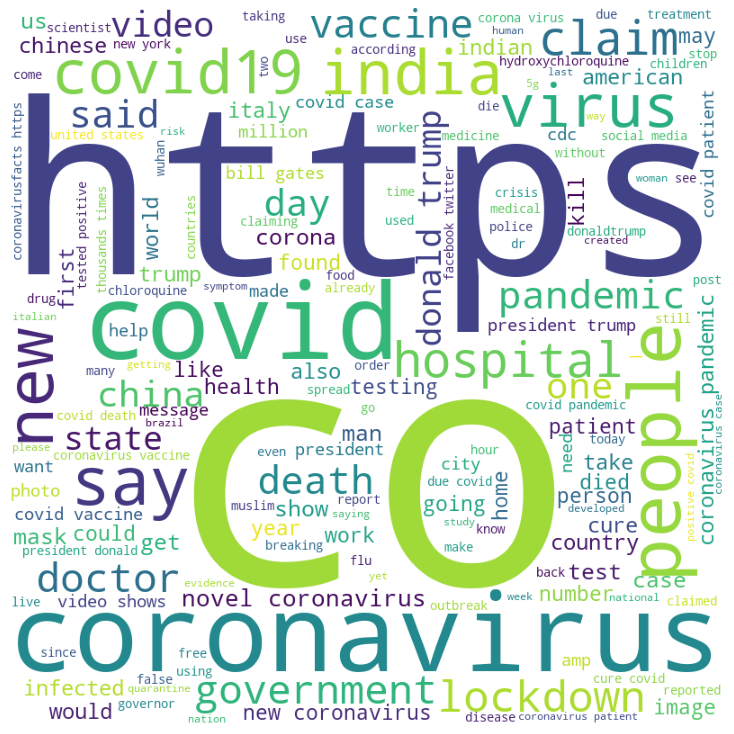

In [69]:
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import matplotlib.pyplot as plt
wordcloud=WordCloud(width=800,height=800,
                   background_color='white',
                   stopwords=stopwords.words('english'),
                   min_font_size=10).generate(all_text_real)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
wordcloud=WordCloud(width=800,height=800,
                   background_color='white',
                   stopwords=stopwords.words('english'),
                   min_font_size=10).generate(all_text_fake)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


count_vectorizer=CountVectorizer(ngram_range=(1,2))
tf_idf_transformer=TfidfTransformer(smooth_idf=False)

count_vectorizer.fit(train["tweet"].values)
count_vect_train=count_vectorizer.transform(train['tweet'].values)

tf_idf_transformer.fit(count_vect_train)
tf_idf_train=tf_idf_transformer.transform(count_vect_train)

count_vect_test=count_vectorizer.transform(test['tweet'].values)
tf_idf_test=tf_idf_transformer.transform(count_vect_test)


In [70]:
tfidf=TfidfVectorizer(smooth_idf=False)
tf_idf_train=tfidf.fit_transform(train["tweet"].values)
tf_idf_test=tfidf.transform(test["tweet"].values)


In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
import time

In [72]:
X_train=tf_idf_train
y_train=train['label'].values
X_test=tf_idf_test
y_test=test['label'].values

le=LabelEncoder()
le.fit(y_train)
y_train=le.transform(y_train)
y_test=le.transform(y_test)
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list=[]

def get_perf_metrics(model,i):
    model_name=type(model).__name__
    start_time =time.time()
    print("Trainning {} model...".format(model_name))
    
    model.fit(X_train,y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [76]:
models_list=[LogisticRegression(),
             SVC(kernel="linear"),
             SVC(kernel='sigmoid'),
             MultinomialNB(),
             RandomForestClassifier(n_estimators=1000, random_state=0),
             DecisionTreeClassifier(),
             GradientBoostingClassifier(),
             AdaBoostClassifier()
            ]
for n,model in enumerate(models_list):
    get_perf_metrics(model,n)

Trainning LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.19 s.
Completed LogisticRegression model's performance assessment.
Trainning SVC model...
Completed SVC model training.
Time elapsed: 3.02 s.
Completed SVC model's performance assessment.
Trainning SVC model...
Completed SVC model training.
Time elapsed: 2.81 s.
Completed SVC model's performance assessment.
Trainning MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.00 s.
Completed MultinomialNB model's performance assessment.
Trainning RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 24.89 s.
Completed RandomForestClassifier model's performance assessment.
Trainning DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 0.55 s.
Completed DecisionTreeClassifier model's performance assessment.
Trainning GradientBoostingClassifier model...
Completed GradientBoostingClassifier m

In [77]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.968380,0.921028,0.911688,0.940179,0.925714,0.19
1,SVC,0.995016,0.933645,0.927448,0.947321,0.937279,3.02
2,SVC,0.984112,0.932710,0.926573,0.946429,0.936396,2.81
3,MultinomialNB,0.964019,0.914019,0.888060,0.956250,0.920894,0.00
4,RandomForestClassifier,1.000000,0.924766,0.923213,0.933929,0.928540,24.89
5,DecisionTreeClassifier,1.000000,0.876168,0.878654,0.885714,0.882170,0.55
6,GradientBoostingClassifier,0.909346,0.887850,0.892857,0.892857,0.892857,2.67
7,AdaBoostClassifier,0.901090,0.892056,0.902992,0.889286,0.896086,0.68


In [75]:
from sklearn.model_selection import GridSearchCV

model=SVC(kernel='sigmoid')

#Best params 1 {'C':10,'max_iter':1000}
#Best params 2 {'C':8,'max_iter':1200} Acc:0.9275
#Best param 3 {'C':3, 'max_iter':1400} Acc:0.9303

max_iter=[1400] 
C = [3]

param_grid = dict(max_iter=max_iter, C=C)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)
print('Best params: ', grid_result.best_params_)

model = grid_result.best_estimator_

y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
/home/vader/anaconda3/envs/rapids/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[CV] END .................................C=3, max_iter=1400; total time=   1.8s
/home/vader/anaconda3/envs/rapids/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[CV] END .................................C=3, max_iter=1400; total time=   1.8s
/home/vader/anaconda3/envs/rapids/lib/python3.7/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)